# imports


In [1]:
import numpy as np
import os 
import math
import random
import datetime
import statistics
import pandas as pd
import seaborn as sn
import yfinance as yf
import matplotlib.pyplot as plt
from numpy import savetxt
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.tree
from sklearn import metrics  
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from numpy import sqrt
from numpy import argmax
from numpy import arange
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import warnings
from sklearn.metrics import precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt
import random


warnings.filterwarnings('ignore')



# usefull function and defining models

In [2]:
def get_dates():
    dates = []
    with open('./data/dates.txt', 'r') as fp:
        for line in fp:
            x = line[:-1]
            dates.append(x)
    return dates

models = {}
# models['CatBoost'] = CatBoostClassifier(iterations=30, depth=6, learning_rate=0.1,logging_level ='Silent')
# models['Support Vector Machines'] = LinearSVC()
# models['Decision Trees'] = DecisionTreeClassifier()
# models['Naive Bayes'] = GaussianNB()
# models['K-Nearest Neighbor'] = KNeighborsClassifier() 
# models['RBF SVM'] = SVC(kernel='rbf',gamma=2, C=10,probability = True)
# models['Gaussian Process'] = GaussianProcessClassifier(1.0 * RBF(1.0))  
models['Neural Net'] = MLPClassifier(alpha=1, max_iter=1000)
models['AdaBoost'] = AdaBoostClassifier() 
models['QDA'] = QuadraticDiscriminantAnalysis()
models['SVC'] = SVC(C = 0.1, gamma =  1, kernel = 'poly', probability=True)
models['Random Forest'] = RandomForestClassifier()
models['Logistic Regression'] = LogisticRegression()


def to_labels(pos_probs, threshold):
     return (pos_probs >= threshold).astype('int')
    
# calculate the threshold based on the roc curve using precision and recoil to determain what would be the best thresh
def get_roc_pre_rec(model,x_validate,y_validate):
    predictions = model.predict_proba(x_validate)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_validate, predictions)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    no_skill = len(y_validate[y_validate==1]) / len(y_validate)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.show()
    return thresholds[ix]

# calculate the threshold based on the roc curve using true positive rate and flase positive rate to determain what would be the best thresh  
def get_roc_tpr_fpr(model,x_validate,y_validate):
    predictions = model.predict_proba(x_validate)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_validate, predictions)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    return thresholds[ix]
#calc threshold based on the F-score of the results   
def get_thresh_Fscore(model,x_validate,y_validate):
    predictions = model.predict_proba(x_validate)[:, 1]
    thresholds = arange(0, 1, 0.001)
    scores = [f1_score(y_validate, to_labels(predictions, t)) for t in thresholds]
    ix = argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return thresholds[ix]

#return the top values as True and other values as False
def top_values(numbers, x):
    sorted_numbers = sorted(numbers, reverse=True)
    top_x = sorted_numbers[:x]
    is_top_value = [False] * len(numbers)
    counter = 0
    for i, number in enumerate(numbers):
        if counter >= x:
            break
        if number in top_x and number >= 0.5 and is_top_value[i] == False:
            is_top_value[i] = True
            counter += 1
            top_x.remove(number)
    return is_top_value
    


In [3]:
def create_sumfile(model,ind,thresh,starting_date,ending_date,save_path):
    dates = get_dates()
    df_model = pd.DataFrame(index = dates[starting_date:ending_date])  
    model_name = model.__class__.__name__
    if "Classifier" in model_name:
        model_name = model_name[:-10]
    print(model_name)
    precision,recall,TpCounter,daily_positive,DailyGainer,positionscounter =[],[],[],[],[],[]
    target_df = pd.read_csv(f"./data/targets/Targets{ind}.csv")
    for i in range(starting_date,ending_date):
        TPcount,TotalGain,positions_opend = 0,0,0
        date_df = pd.read_csv(f"./data/dates{ind}/{dates[i]}.csv")
        next_date_df = pd.read_csv(f"./data/dates{ind}/{dates[i+1]}.csv")
        results_df = pd.read_csv(f"./data/dates{ind}/{dates[i+2]}.csv") 
        x_train = date_df.drop(['ticker'], axis=1)                                     #the current day data
        x_validate = next_date_df.drop(['ticker'], axis=1)                             #next day data
        y_train = target_df[dates[i+1]]                                                #takes the next day target
        y_validate = target_df[dates[i+2]]                                             #day after the next target
        scaler = preprocessing.StandardScaler()                                        #define scaler
        x_train, x_validate = scaler.fit_transform(x_train),scaler.fit_transform(x_validate)
        if y_train.sum() == 0 or y_train.sum() == 1 :
            precision.append(0)
            recall.append(0)
            daily_positive.append(0)
            DailyGainer.append(0)
            TpCounter.append(0)
            positionscounter.append(0)
        else: 
            model.fit(x_train, y_train) 
            predictions = top_values(model.predict_proba(x_validate)[:,1],thresh)
            precision.append(precision_score(y_validate, predictions))
            recall.append(recall_score(y_validate, predictions))
            daily_positive.append(target_df[dates[i+2]].sum())
            for j in range(len(predictions)):
                if predictions[j] == True:
                    positions_opend +=1
                    TotalGain = TotalGain + round(results_df.at[j, 'Close Change']*100,2)
                    if y_validate[j] == 1 :
                        TPcount +=1
            TpCounter.append(TPcount)
            positionscounter.append(positions_opend)
            if(positions_opend == 0):
                DailyGainer.append(0)
                
            else:
                DailyGainer.append(TotalGain/positions_opend)
        
    df_model[f'P-{model_name}'] = precision
    df_model[f'R-{model_name}'] = recall
    df_model[f'TP-{model_name}'] = TpCounter
    df_model[f'DG-{model_name}'] = DailyGainer
    df_model[f'DPO-{model_name}'] = positionscounter
    df_model['DP'] = daily_positive
    df_model.to_csv(f'{save_path}/{ind}/{model_name}-{ind}-{thresh}.csv',index=False)

# running the function to create files

In [4]:
indices = [2.5,2,1.5]
threshes = [5,20,50,100]
# date_ranges = ['01.09.2020-30.09.2020','25.03.2021-23.04.2021','23.03.2020-29.04.2020','02.03.2020-23.03.2020']
for key in models.keys():
    for ind in indices:
        for thresh in threshes:
            create_sumfile(models[key],ind,thresh,209, 225,"./data/PrecisionTesting/02.03.2020-23.03.2020")
            create_sumfile(models[key],ind,thresh,224, 251,"./data/PrecisionTesting/23.03.2020-29.04.2020")
            create_sumfile(models[key],ind,thresh,337, 358,"./data/PrecisionTesting/01.09.2020-30.09.2020")
            create_sumfile(models[key],ind,thresh,478, 499,"./data/PrecisionTesting/25.03.2021-23.04.2021")
             

MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscrim

In [5]:
def sort_file_list(file_list):
    def sorting_key(filename):
        parts = filename.split('-')
        return (parts[0], int(parts[2].split('.')[0]))   
    sorted_file_list = sorted(file_list, key=sorting_key)
    return sorted_file_list

def combine_csv_files(folder_path, ind):
    dataframes = []
    file_list = os.listdir(folder_path)
    file_list_sorted = sort_file_list(file_list)
    for csv_file in file_list_sorted:
        if csv_file.endswith('.csv'):
            file_path = os.path.join(folder_path, csv_file)
            temp_df = pd.read_csv(file_path, usecols=[0, 1, 2, 3, 4])
            dataframes.append((temp_df, csv_file))
    
    df = pd.concat([x[0] for x in dataframes], axis=1, keys=[x[1] for x in dataframes])
    df.to_csv(os.path.join(folder_path, f'../finals/f{ind}.csv'), index=False)

combine_csv_files('./data/PrecisionTesting/25.03.2021-23.04.2021/1.5/',1.5)
combine_csv_files('./data/PrecisionTesting/25.03.2021-23.04.2021/2/',2)
combine_csv_files('./data/PrecisionTesting/25.03.2021-23.04.2021/2.5/',2.5)

In [6]:
def stack_csv_files(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    stacked_data = pd.DataFrame()
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path)
        stacked_data = pd.concat([stacked_data, data, pd.DataFrame(index=range(2), columns=data.columns)], axis=0)
    output_file_path = os.path.join(folder_path, 'stacked_data.xlsx')
    stacked_data.to_excel(output_file_path, index=False)

    
stack_csv_files('./data/PrecisionTesting/25.03.2021-23.04.2021/finals')

# create graphs of statistics


============== red area =============


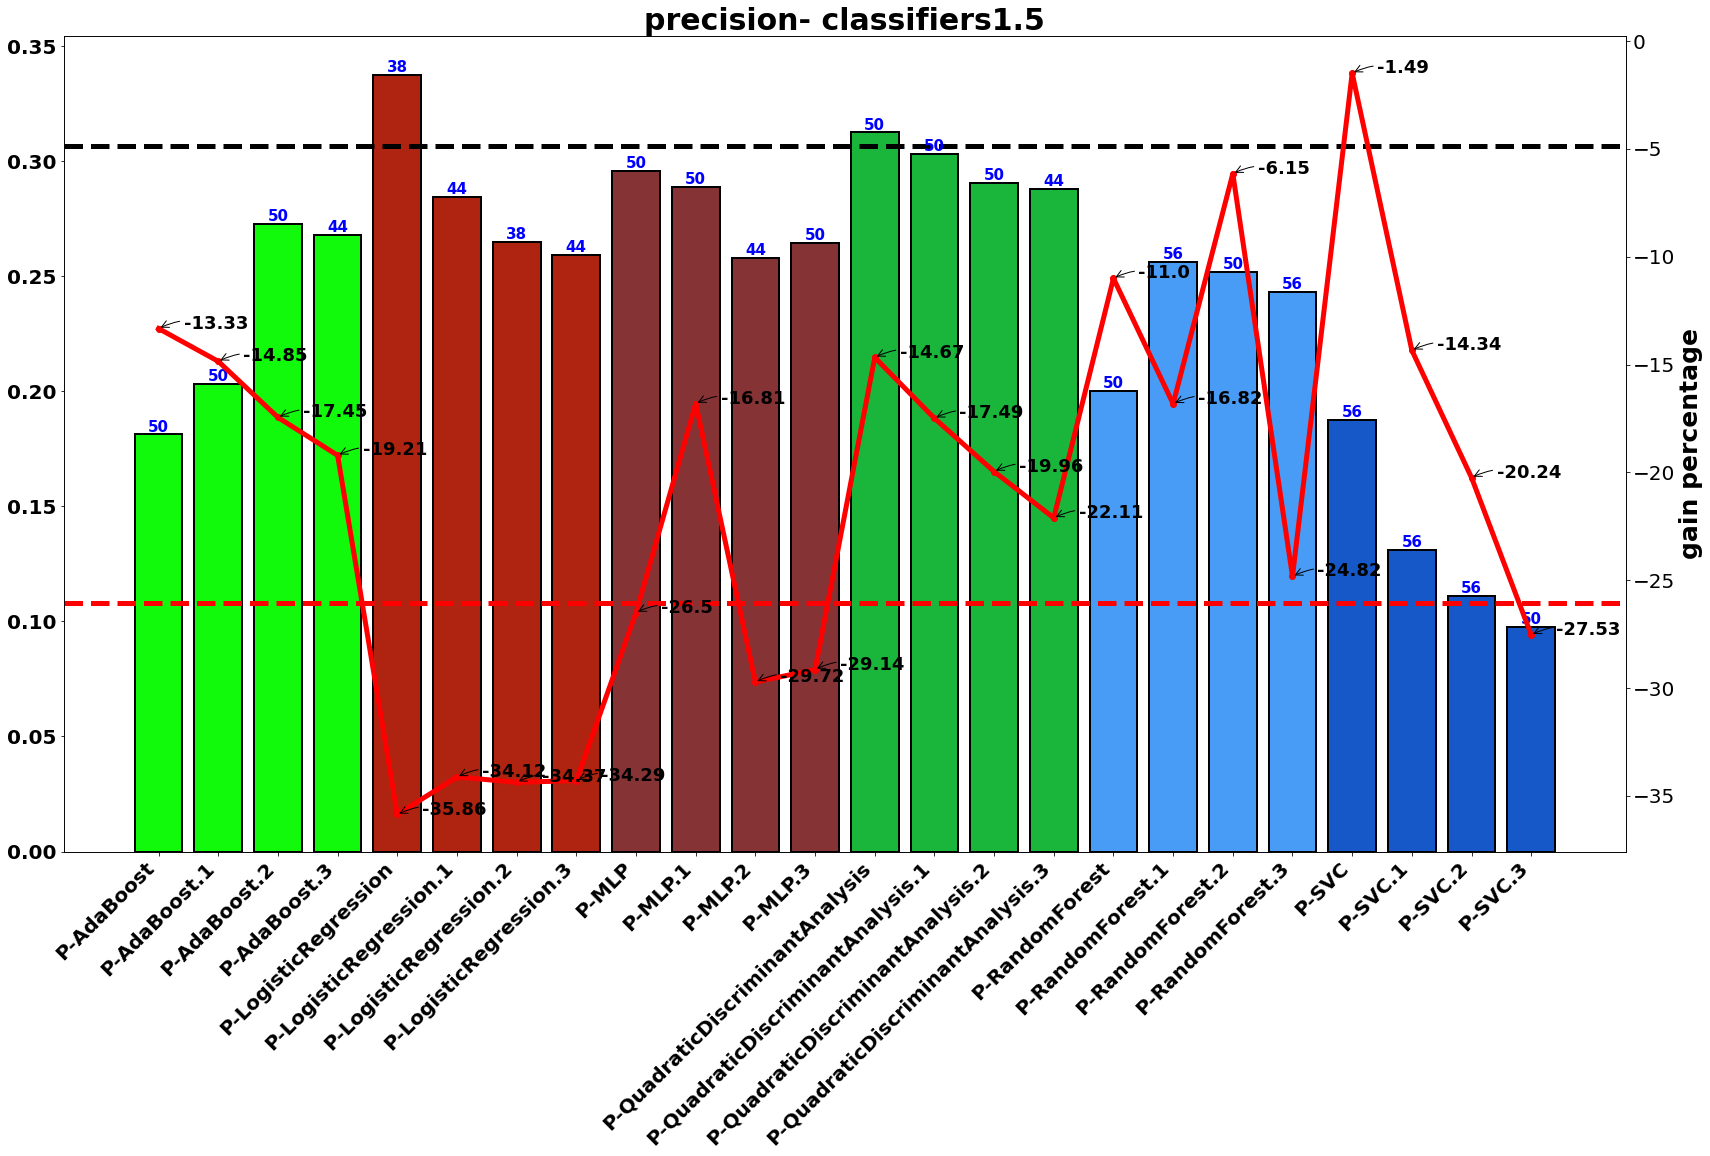

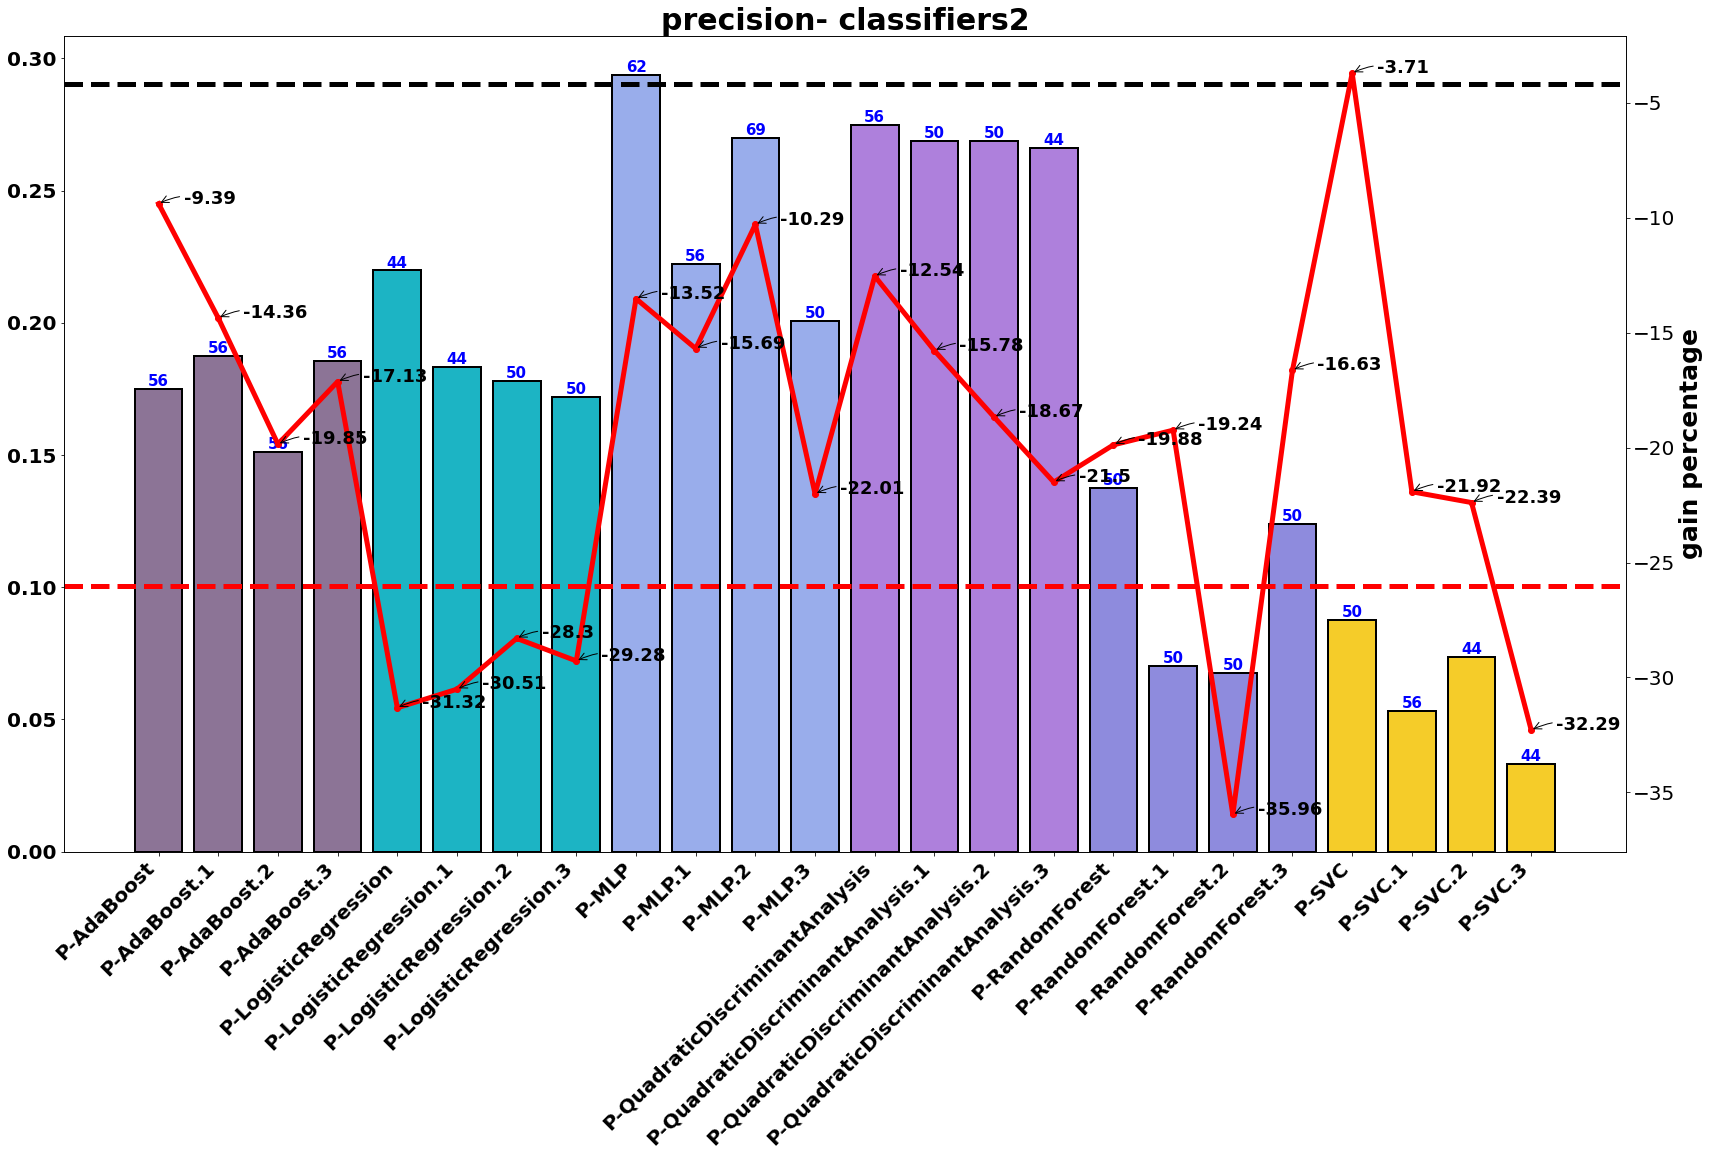

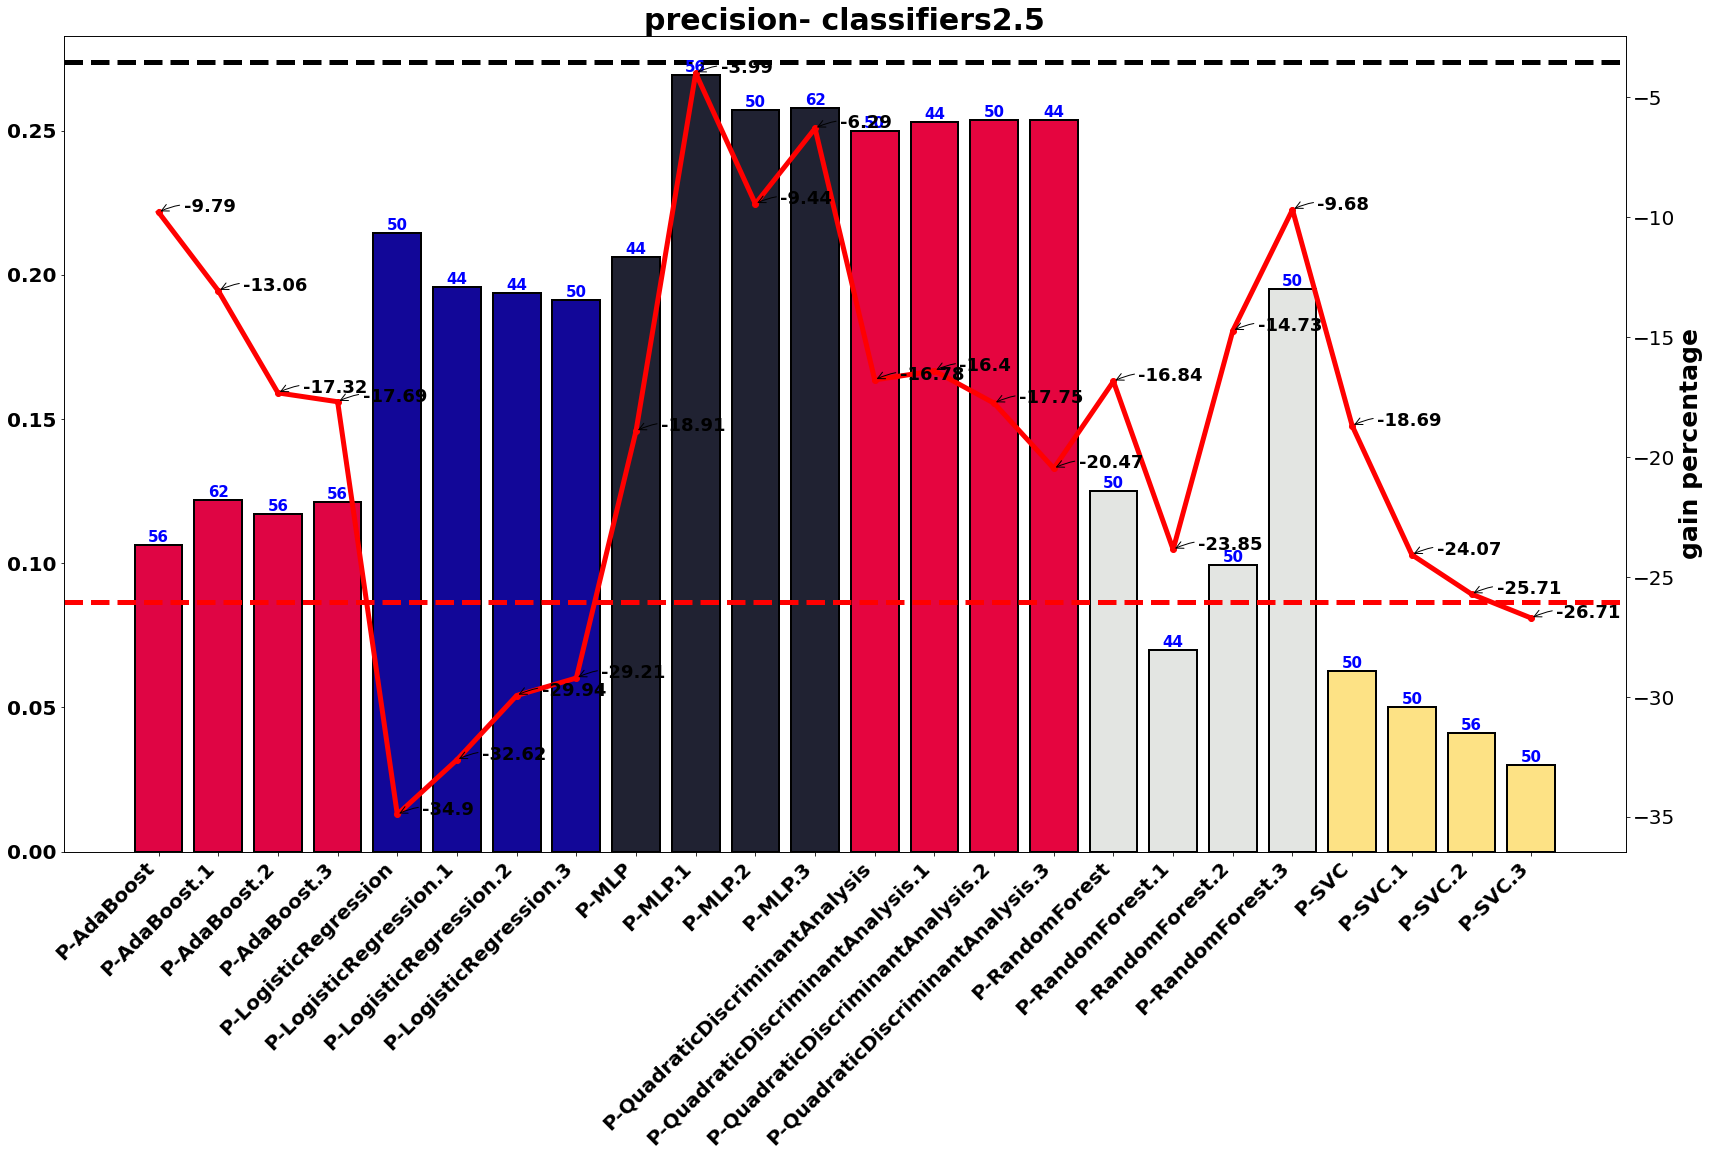

============== blue area =============


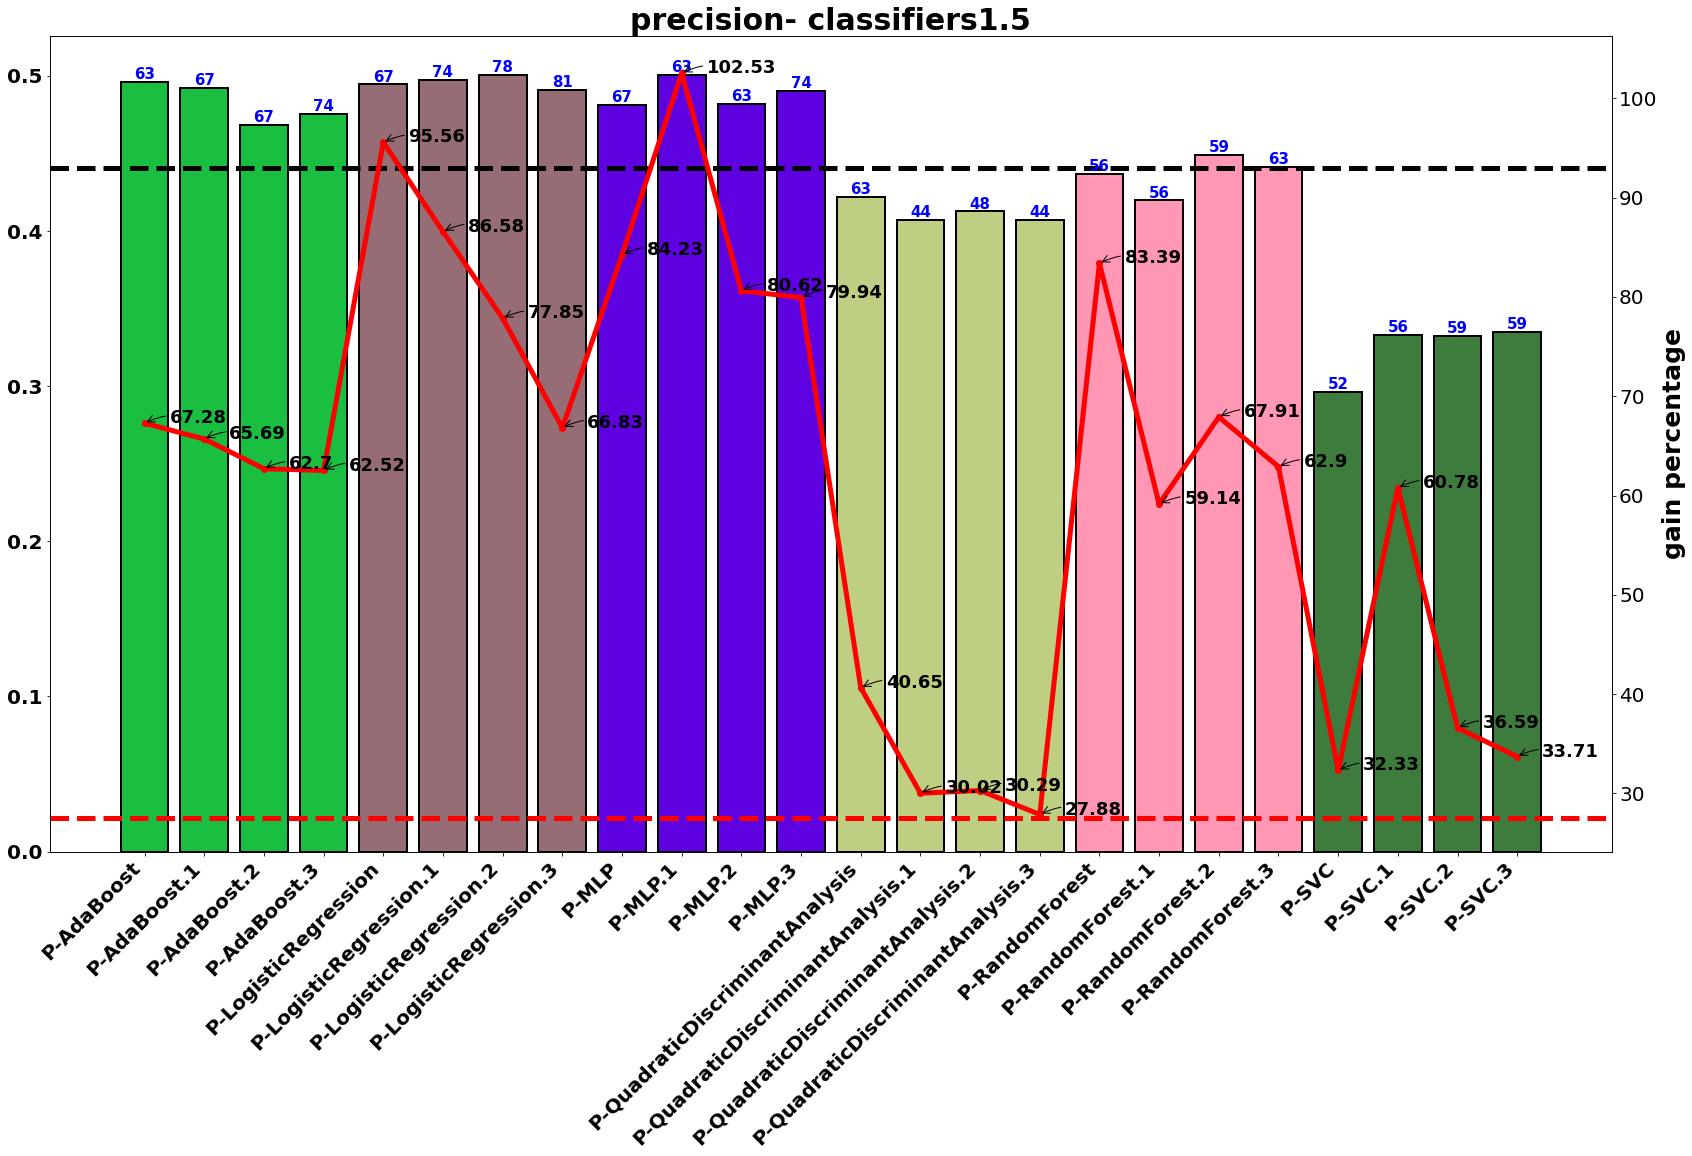

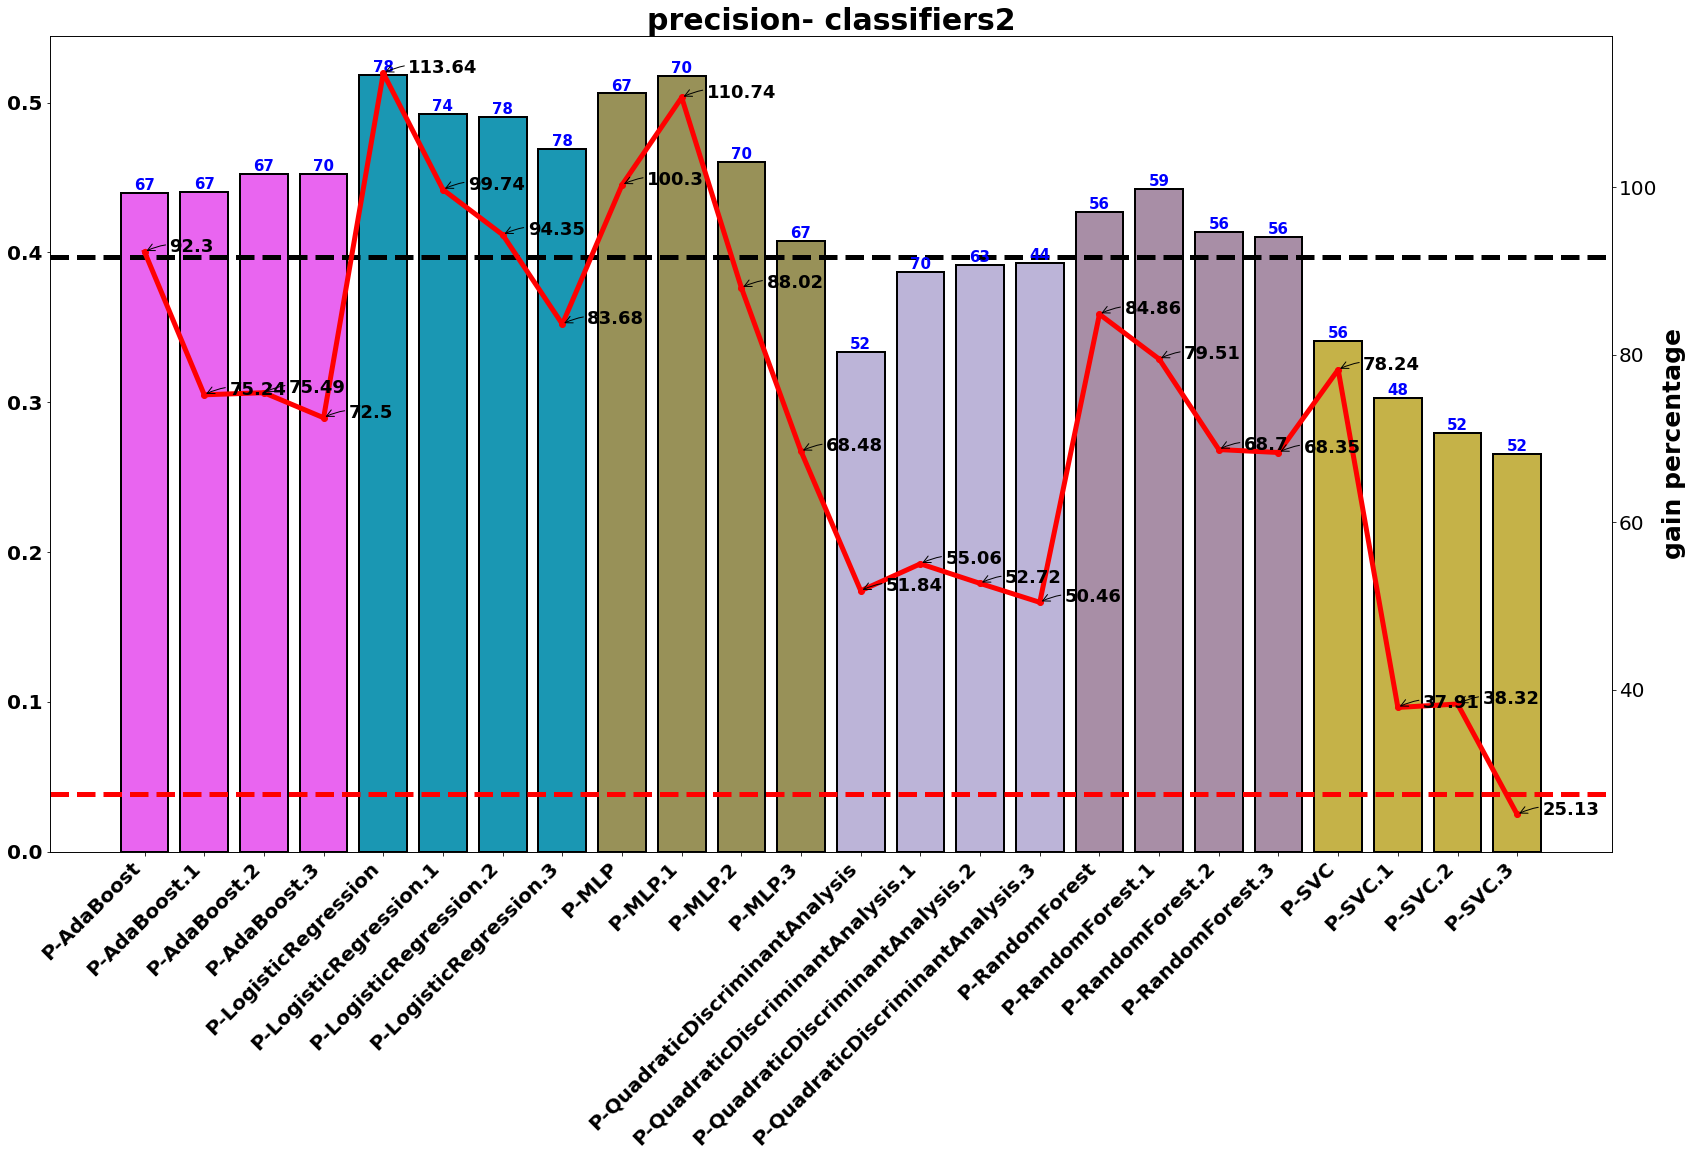

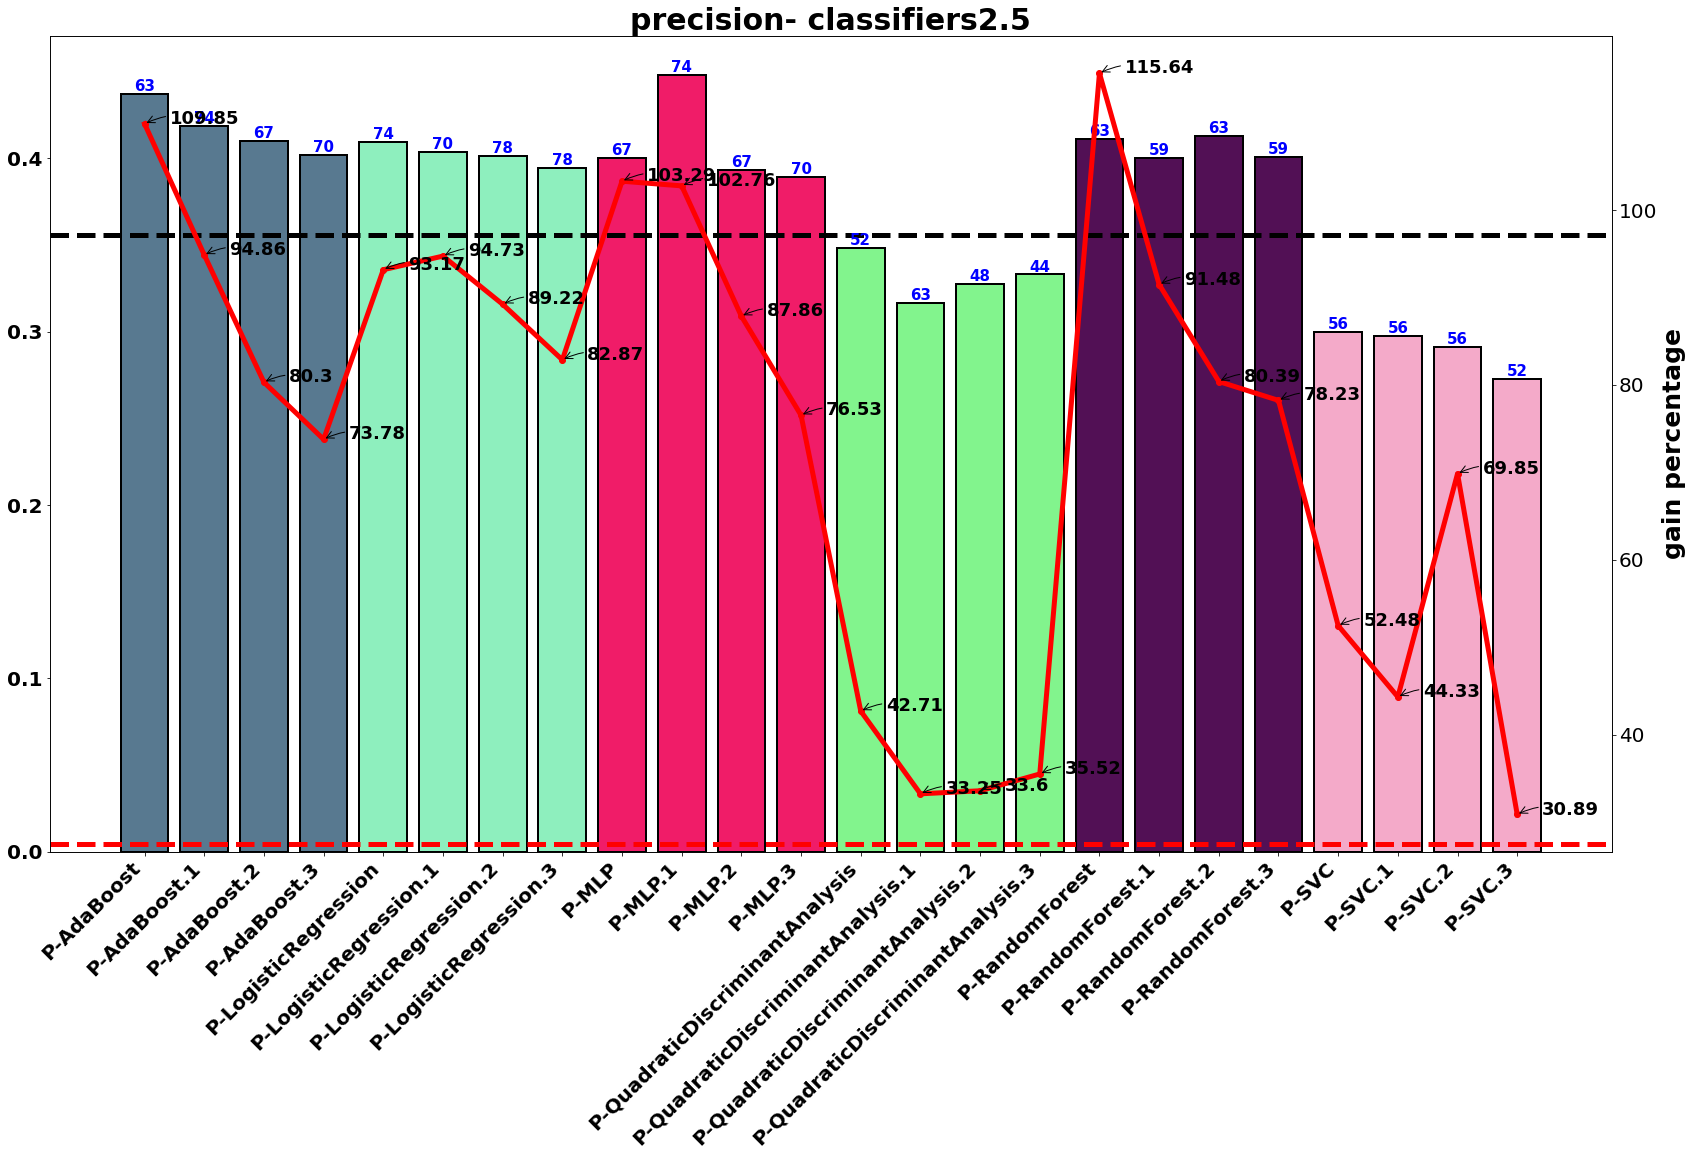

============== purple area =============


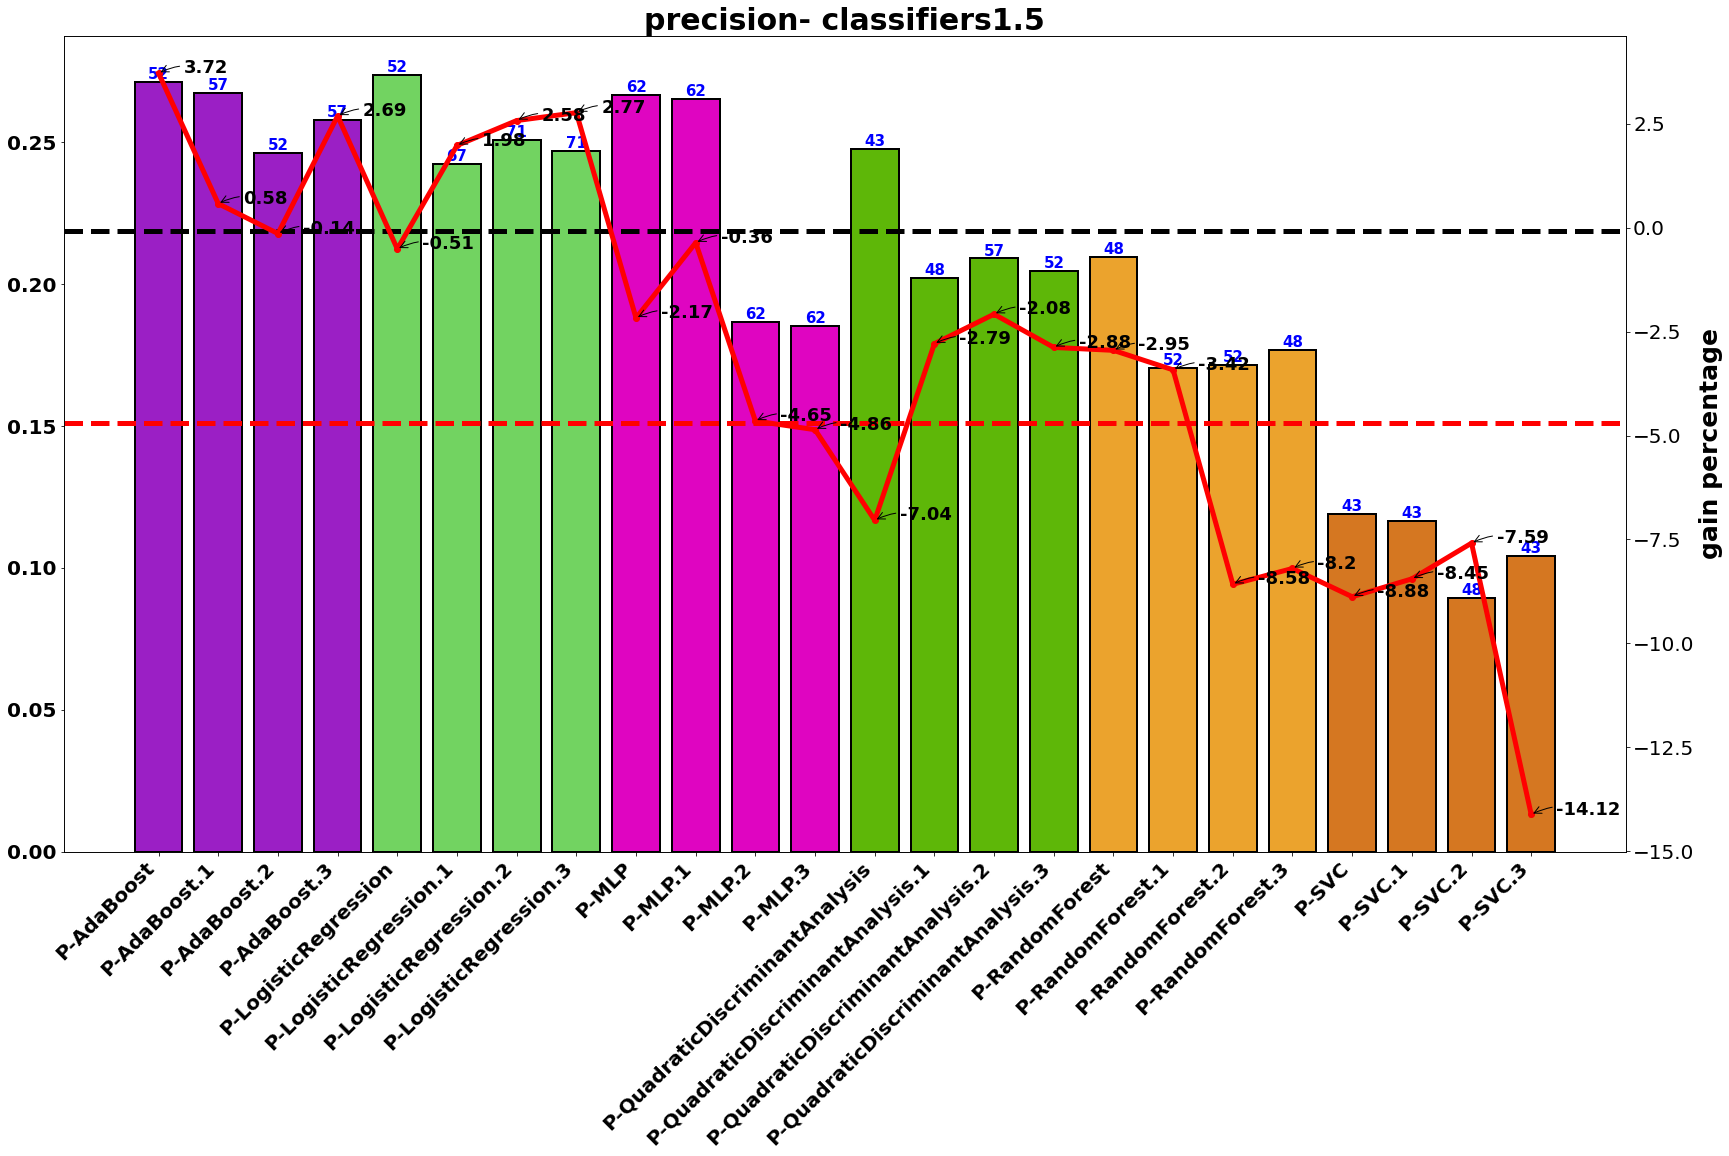

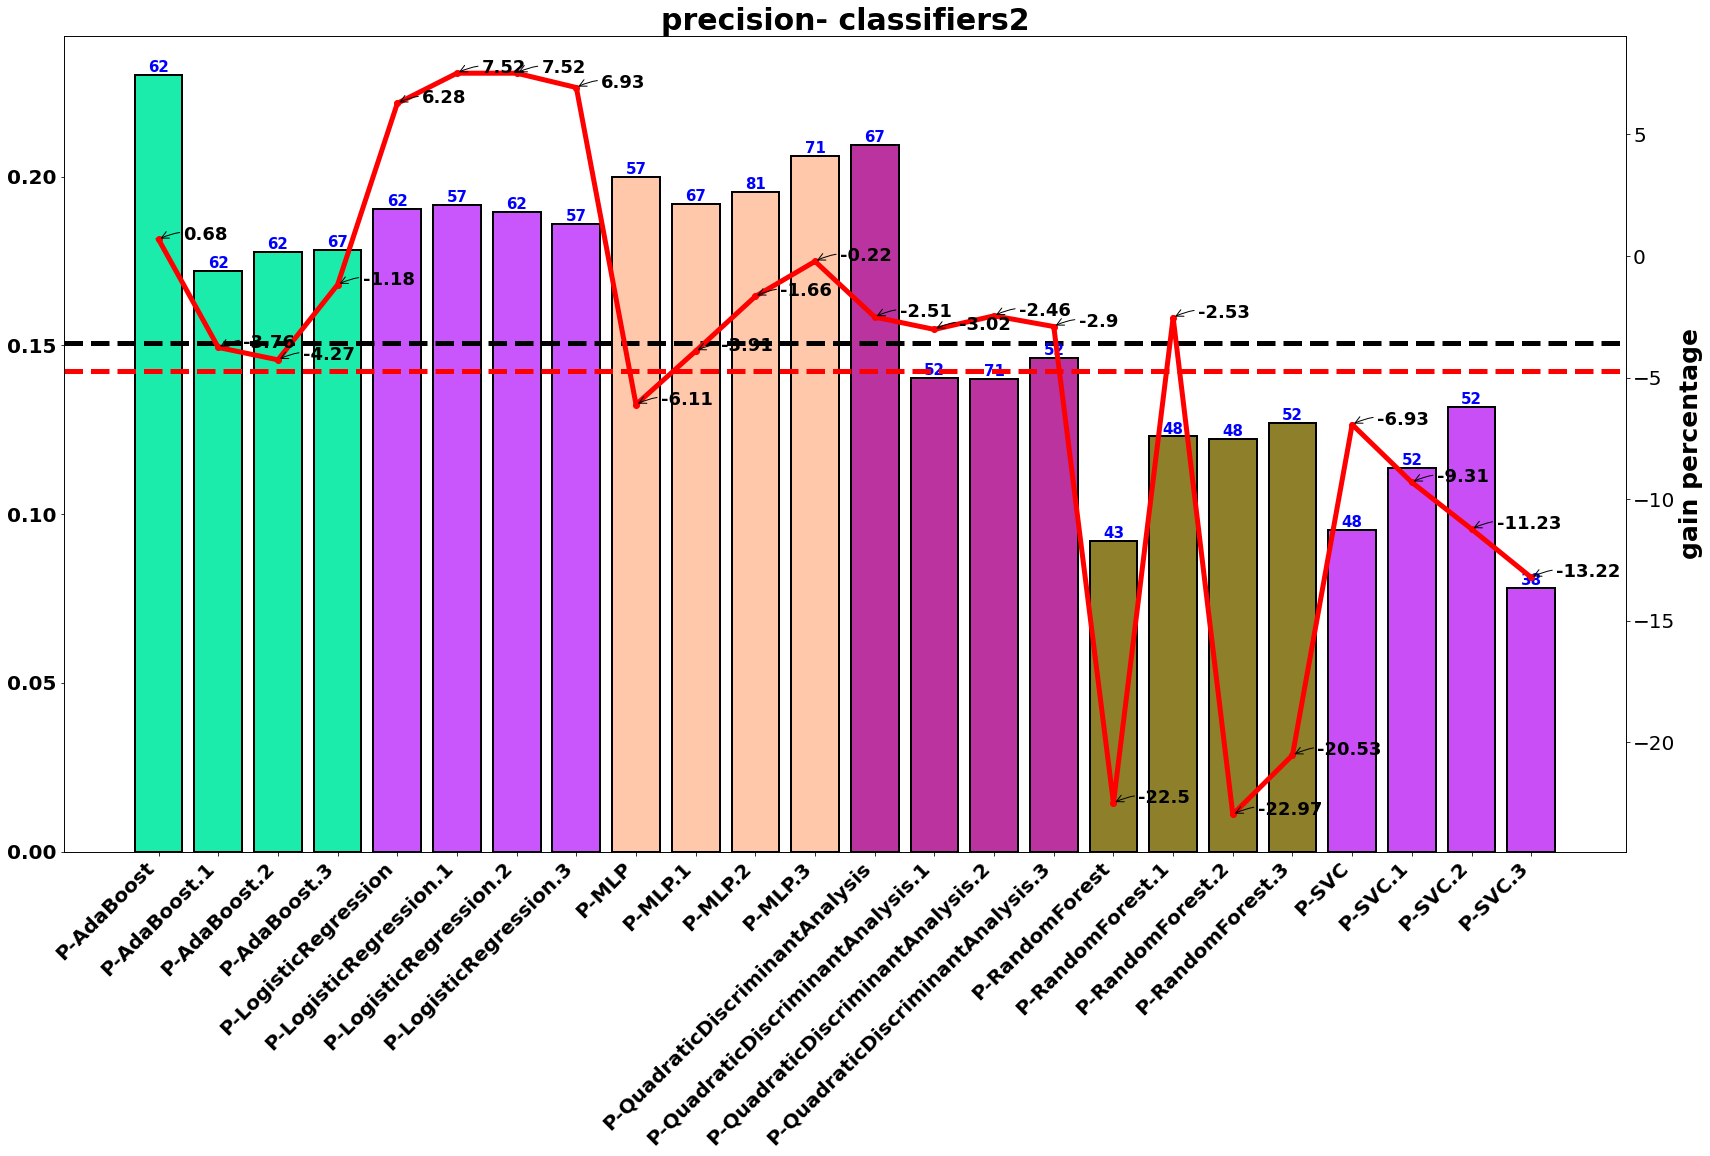

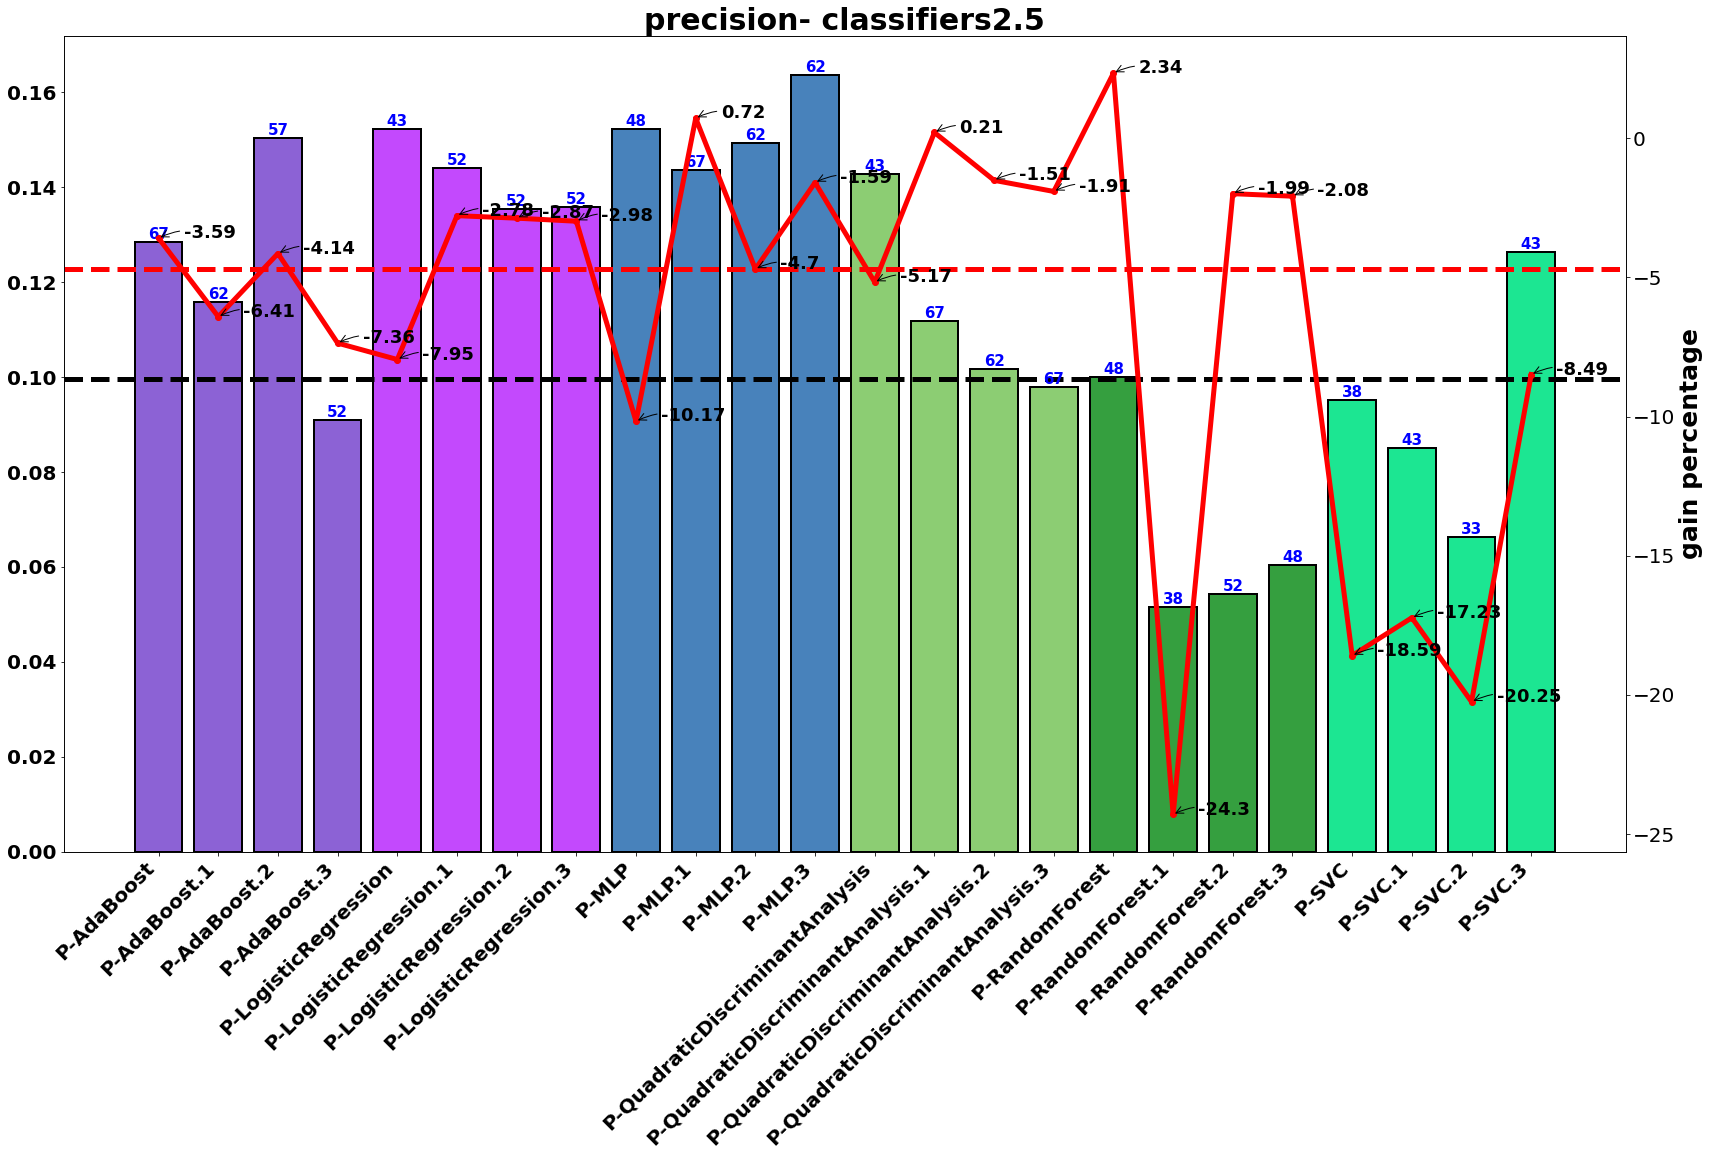

============== green area =============


TypeError: Could not convert ['P-AdaBoost0.41.00.20.00.60.20.20.00.00.00.00.20.00.20.40.00.00.00.20.00.4'
 'P-AdaBoost0.450.750.150.28571428571428570.550.35714285714285710.20.050.00.00.050.10.00.15789473684210520.20.050.00.00.09090909090909090.00.1666666666666666'
 'P-AdaBoost0.45454545454545450.660.120.28571428571428570.47222222222222220.35714285714285710.20.060.00.00.10714285714285710.18750.00.15789473684210520.23333333333333330.120.00.00.09090909090909090.020.2'
 'P-AdaBoost0.45454545454545450.620.120.28571428571428570.47222222222222220.35714285714285710.220.070.00.00.10714285714285710.18750.00.15789473684210520.23333333333333330.15476190476190470.00.00.09090909090909090.040.1666666666666666'
 'P-LogisticRegression0.40.40.00.20.40.20.00.00.00.00.00.20.60.20.40.20.00.00.20.00.6'
 'P-LogisticRegression0.450.550.10.20.550.150.20.050.050.00.00.050.350.30.40.10.050.00.50.10.5'
 'P-LogisticRegression0.560.60.10.17857142857142850.48780487804878050.36111111111111110.180.10.02040816326530610.00.05555555555555550.020.29629629629629630.33333333333333330.35483870967741940.160.020.00.44117647058823530.10.5'
 'P-LogisticRegression0.56603773584905660.670.10.17857142857142850.48780487804878050.36111111111111110.190.090.02040816326530610.00.05555555555555550.020.29629629629629630.33333333333333330.35483870967741940.160.02739726027397260.00.44117647058823530.070.5'
 'P-MLP0.80.20.20.20.60.20.20.00.00.00.00.00.40.60.60.60.20.00.20.21.0'
 'P-MLP0.350.50.150.13333333333333330.70.40.150.00.00.00.05263157894736840.050.40.40.31250.20.050.00.18750.051.0'
 'P-MLP0.41666666666666670.680.10.17647058823529410.61363636363636360.46666666666666670.120.020.05555555555555550.00.05882352941176470.040.33333333333333330.35294117647058820.28571428571428570.160.02380952380952380.00.21052631578947360.061.0'
 'P-MLP0.48484848484848480.660.140.20.57142857142857140.46153846153846150.160.060.0645161290322580.00.13636363636363630.04761904761904760.33333333333333330.50.28571428571428570.130.02173913043478260.00.22222222222222220.051.0'
 'P-QuadraticDiscriminantAnalysis0.20.60.00.20.20.20.40.00.40.20.60.20.40.00.60.00.00.00.20.00.2'
 'P-QuadraticDiscriminantAnalysis0.30.80.00.050.20.350.450.00.20.20.30.050.30.10.650.050.00.00.10.00.3'
 'P-QuadraticDiscriminantAnalysis0.280.740.060.060.140.340.380.020.080.160.220.020.220.120.520.080.040.020.160.00.38'
 'P-QuadraticDiscriminantAnalysis0.260.70.080.10.18750.310.350.040.040.130.210.030.170.120.40.110.020.04615384615384610.240.010.37'
 'P-RandomForest0.33333333333333330.40.00.00.20.60.40.00.00.00.20.00.00.00.00.20.00.00.00.01.0'
 'P-RandomForest0.42857142857142850.60.050.00.30769230769230770.42857142857142850.20.00.06250.00.250.00.00.10.07142857142857140.150.00.00.00.051.0'
 'P-RandomForest0.14285714285714280.540.040.00.50.47368421052631570.220.020.06250.00.160.00.00.09090909090909090.00.06122448979591830.00.00.00.041.0'
 'P-RandomForest0.33333333333333330.560.030.00.47368421052631570.50.21794871794871790.02247191011235950.10.00.250.07142857142857140.00.06666666666666660.00.1730769230769230.00.00.00.051.0'
 'P-SVC0.66666666666666660.40.00.00.40.80.20.00.00.00.20.00.00.00.00.40.00.00.50.00.5'
 'P-SVC0.50.350.00.00.28571428571428570.83333333333333340.20.050.00.00.20.00.00.00.00.250.00.00.750.00.0'
 'P-SVC0.00.540.040.00.3750.83333333333333340.16666666666666660.08571428571428570.00.00.00.00.00.00.00.27777777777777780.00.00.50.040.0'
 'P-SVC0.66666666666666660.63265306122448980.050.00.28571428571428570.750.20.08571428571428570.00.00.16666666666666660.00.00.00.00.18750.00.00.50.00.0'] to numeric

In [7]:
# calc how much percentage was made in a range of dates
def total_portfolio_value(daily_gains):
    portfolio_value = 1
    for gain in daily_gains:
        portfolio_value *= (1 + gain/100)
    return round(((portfolio_value-1)*100),2)

# return percentage of bigger item in list one over list 2 
def percentage_bigger(list1, list2):
    count = 0
    total = len(list1)
    for i, j in zip(list1, list2):
        if i > j:
            count += 1
    percentage = count / total * 100
    return round(percentage)

# creates percision graph of all classifiers 
def get_precision_graph(ind ,name,start_date, end_date,path):
    df = pd.read_csv(f"{path}/f{ind}.csv")
    sp_df = pd.read_csv(f"./data/S&Pdata/S&P500.csv")
    sp_df = sp_df[start_date:end_date]
    # sets the S&P data frame to the selected dates
    sp_per = sum(sp_df[f'precision{ind}'])/(end_date-start_date)
#     print(sp_df['Date'])
    # gets precision 
    sp_gain = sp_df['Close Change']
    sp_profit  = total_portfolio_value(sp_gain)
    bar_positions = [i for i in range(24)]
    values = df.iloc[:,::5].mean()
    x_ticks = values.index.tolist()
    titles , totgains =[], []
    daily_gains = df.iloc[:,3::5]
    for dg in daily_gains.columns:
        cnt = 0
        col = daily_gains[dg] 
        titles.append(percentage_bigger(col.tolist(),sp_gain.tolist()))  
        totgains.append(total_portfolio_value(col))
        
    fig, ax = plt.subplots(figsize=(28,15))
    num_groups = len(values) // 4
    num_bars = len(values) // num_groups
    colors = ['#{:06x}'.format(random.randint(0, 2**24 - 1)) for _ in range(num_groups)]
    for i in range(num_groups):
        for j in range(4):
            index = i*4 + j
            ax.bar(index, values[index], color=colors[i], ec='black', lw=2)
            ax.text(index, values[index], titles[index], ha='center', va='bottom', fontsize=15, weight='bold',color ='blue')
    ax.set_xticks(range(len(x_ticks)))
    ax.set_xticklabels(x_ticks, rotation=45, ha='right', fontsize=20, weight='bold')
    plt.yticks(fontsize=20, weight='bold')
    plt.title(f"{name}- classifiers{ind}", fontsize=30, weight='bold')
    ax.axhline(sp_per, color='black', linestyle='--', linewidth =5)
    ax2 = ax.twinx()
    ax2.set_ylabel('gain percentage', fontsize=25, weight='bold')
#     ax2.set_ylim([-20,100])
    ax2.tick_params(axis='y', labelsize=20)
    ax2.plot(bar_positions, totgains, '-o', color='red', linewidth =5)
    ax2.axhline(sp_profit, color='red', linestyle='--', linewidth =5)

    for i, j in zip(bar_positions, totgains):
        ax2.annotate(str(j), xy=(i, j), xycoords='data',
                     xytext=(25, 0), textcoords='offset points',
                     fontsize=18, weight='bold',
                     arrowprops=dict(arrowstyle="->",
                                     connectionstyle="arc3,rad=0.2"))
    plt.show()
    

print("============== red area =============")
get_precision_graph(1.5,'precision',208, 225,"./data/PrecisionTesting/02.03.2020-23.03.2020/finals")
get_precision_graph(2,'precision',208, 225,"./data/PrecisionTesting/02.03.2020-23.03.2020/finals")
get_precision_graph(2.5,'precision',208, 225,"./data/PrecisionTesting/02.03.2020-23.03.2020/finals")


print("============== blue area =============")
get_precision_graph(1.5,'precision',225, 252,"./data/PrecisionTesting/23.03.2020-29.04.2020/finals")
get_precision_graph(2,'precision',225, 252,"./data/PrecisionTesting/23.03.2020-29.04.2020/finals")
get_precision_graph(2.5,'precision',225, 252,"./data/PrecisionTesting/23.03.2020-29.04.2020/finals")


print("============== purple area =============")
get_precision_graph(1.5,'precision',338, 358,"./data/PrecisionTesting/01.09.2020-30.09.2020/finals")
get_precision_graph(2,'precision',338, 358,"./data/PrecisionTesting/01.09.2020-30.09.2020/finals")
get_precision_graph(2.5,'precision',338, 358,"./data/PrecisionTesting/01.09.2020-30.09.2020/finals")


print("============== green area =============")
get_precision_graph(1.5,'precision',479, 499,"./data/PrecisionTesting/25.03.2021-23.04.2021/finals")
get_precision_graph(2,'precision',479, 499,"./data/PrecisionTesting/25.03.2021-23.04.2021/finals")
get_precision_graph(2.5,'precision',479, 499,"./data/PrecisionTesting/25.03.2021-23.04.2021/finals")

In [ ]:
sp_df = pd.read_csv(f"./data/S&Pdata/S&P500.csv")
sp_df = sp_df[208: 225]
sp_precision = sum(sp_df[f'precision2'])/16
sp_gain = sp_df['Close Change']
sp_profit  = total_portfolio_value(sp_gain)
date_ranges = ['01.09.2020-30.09.2020','25.03.2021-23.04.2021','23.03.2020-29.04.2020','02.03.2020-23.03.2020']
folder_path = "./data/PrecisionTesting/pres/02.03.2020-23.03.2020"
# for dates in date_ranges: 
#     folder_path = f"{path}/{dates}"
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  
        df = pd.read_csv(os.path.join(folder_path, filename))
        precision = df.iloc[:, 0].mean()
        better_percentage = percentage_bigger(df.iloc[:, 3].tolist(),sp_gain.tolist())
        totgains = total_portfolio_value(df.iloc[:, 3].tolist())
        print(f"precision : {round(precision,3)} , tot_gains : {totgains} , better percentage : {better_percentage}")
print(round(sp_precision,3),sp_profit)        



# precisions = df.iloc[:,::5].mean()
# titles , totgains =[], []
# daily_gains = df.iloc[:,3::5]
# for dg in daily_gains.columns:
#     cnt = 0
#     col = daily_gains[dg] 
#     titles.append(percentage_bigger(col.tolist(),sp_gain.tolist()))  
#     totgains.append(total_portfolio_value(col))
# #     table = pd.concat([df], keys=['', 'Header'], axis=1)



# create statistic for all classifiers in a single file

In [ ]:
dataframes = {}
for key in models.keys():
    dates = get_dates()
    df_model = pd.DataFrame(index = dates[350:370])  
    model_name = models[key].__class__.__name__
    daily_positive,f_score,accuracy, precision, recall,TpCounter =[],[],[],[],[],[]
    for i in range(350,370):
        TPcount = 0
        date_df = pd.read_csv(f"./data/dates/{dates[i]}.csv")
        next_date_df = pd.read_csv(f"./data/dates/{dates[i+1]}.csv")
        x_train = date_df.drop(['ticker'], axis=1)                                     #the current day data
        x_validate = next_date_df.drop(['ticker'], axis=1)                             #next day data
        y_train = target_df[dates[i+1]]                                                #takes the next day target
        y_validate = target_df[dates[i+2]]                                             #day after the next target
        scaler = preprocessing.StandardScaler()                                        #define scaler
        x_train, x_validate = scaler.fit_transform(x_train),scaler.fit_transform(x_validate)
        models[key].fit(x_train, y_train) 
        predictions = models[key].predict(x_validate)
        accuracy.append(accuracy_score(y_validate, predictions))
        precision.append(precision_score(y_validate, predictions))
        recall.append(recall_score(y_validate, predictions))
        f_score.append(f1_score(y_validate, predictions))
        daily_positive.append(target_df[dates[i+2]].sum())
        for j in range(len(predictions)):
            if y_validate[j] == 1 and predictions[j] == 1:
                TPcount +=1;
        TpCounter.append(TPcount)
    df_model[f'Precision-{model_name}'] = precision
    df_model[f'accuracy-{model_name}'] = accuracy
    df_model[f'recall-{model_name}'] = recall
    df_model[f'f_score-{model_name}'] = f_score
    df_model[f'TPcounter-{model_name}'] = TpCounter
    df_model['daily_positive'] = daily_positive
    dataframes[model_name]= df_model

    
writer = pd.ExcelWriter('./data/ModelsInformation.xlsx', engine='xlsxwriter')
for sheet_name, df in dataframes.items():
    df.to_excel(writer, sheet_name=sheet_name)
#     df_model.to_excel("./data/ModelsInformation.xlsx",sheet_name=f'{model_name}')
writer.save()

# seperate the model information to files containing specific data

In [ ]:
content = ['Precision','accuracy','recall','f_score']
df_dict = pd.read_excel('./data/models_information/ModelsInformation.xlsx', sheet_name=None)
dates = get_dates()
for amuda in content:
    df2 = pd.DataFrame(index = dates[350:370])  
    for name, df in df_dict.items():
        col = df.loc[:,df.columns.str.contains(f'^{amuda}')]
        df2[f"{amuda}-{name}"] = col.values
    df2.to_csv(f'./data/models_information/all{amuda}.csv',index= False)

    

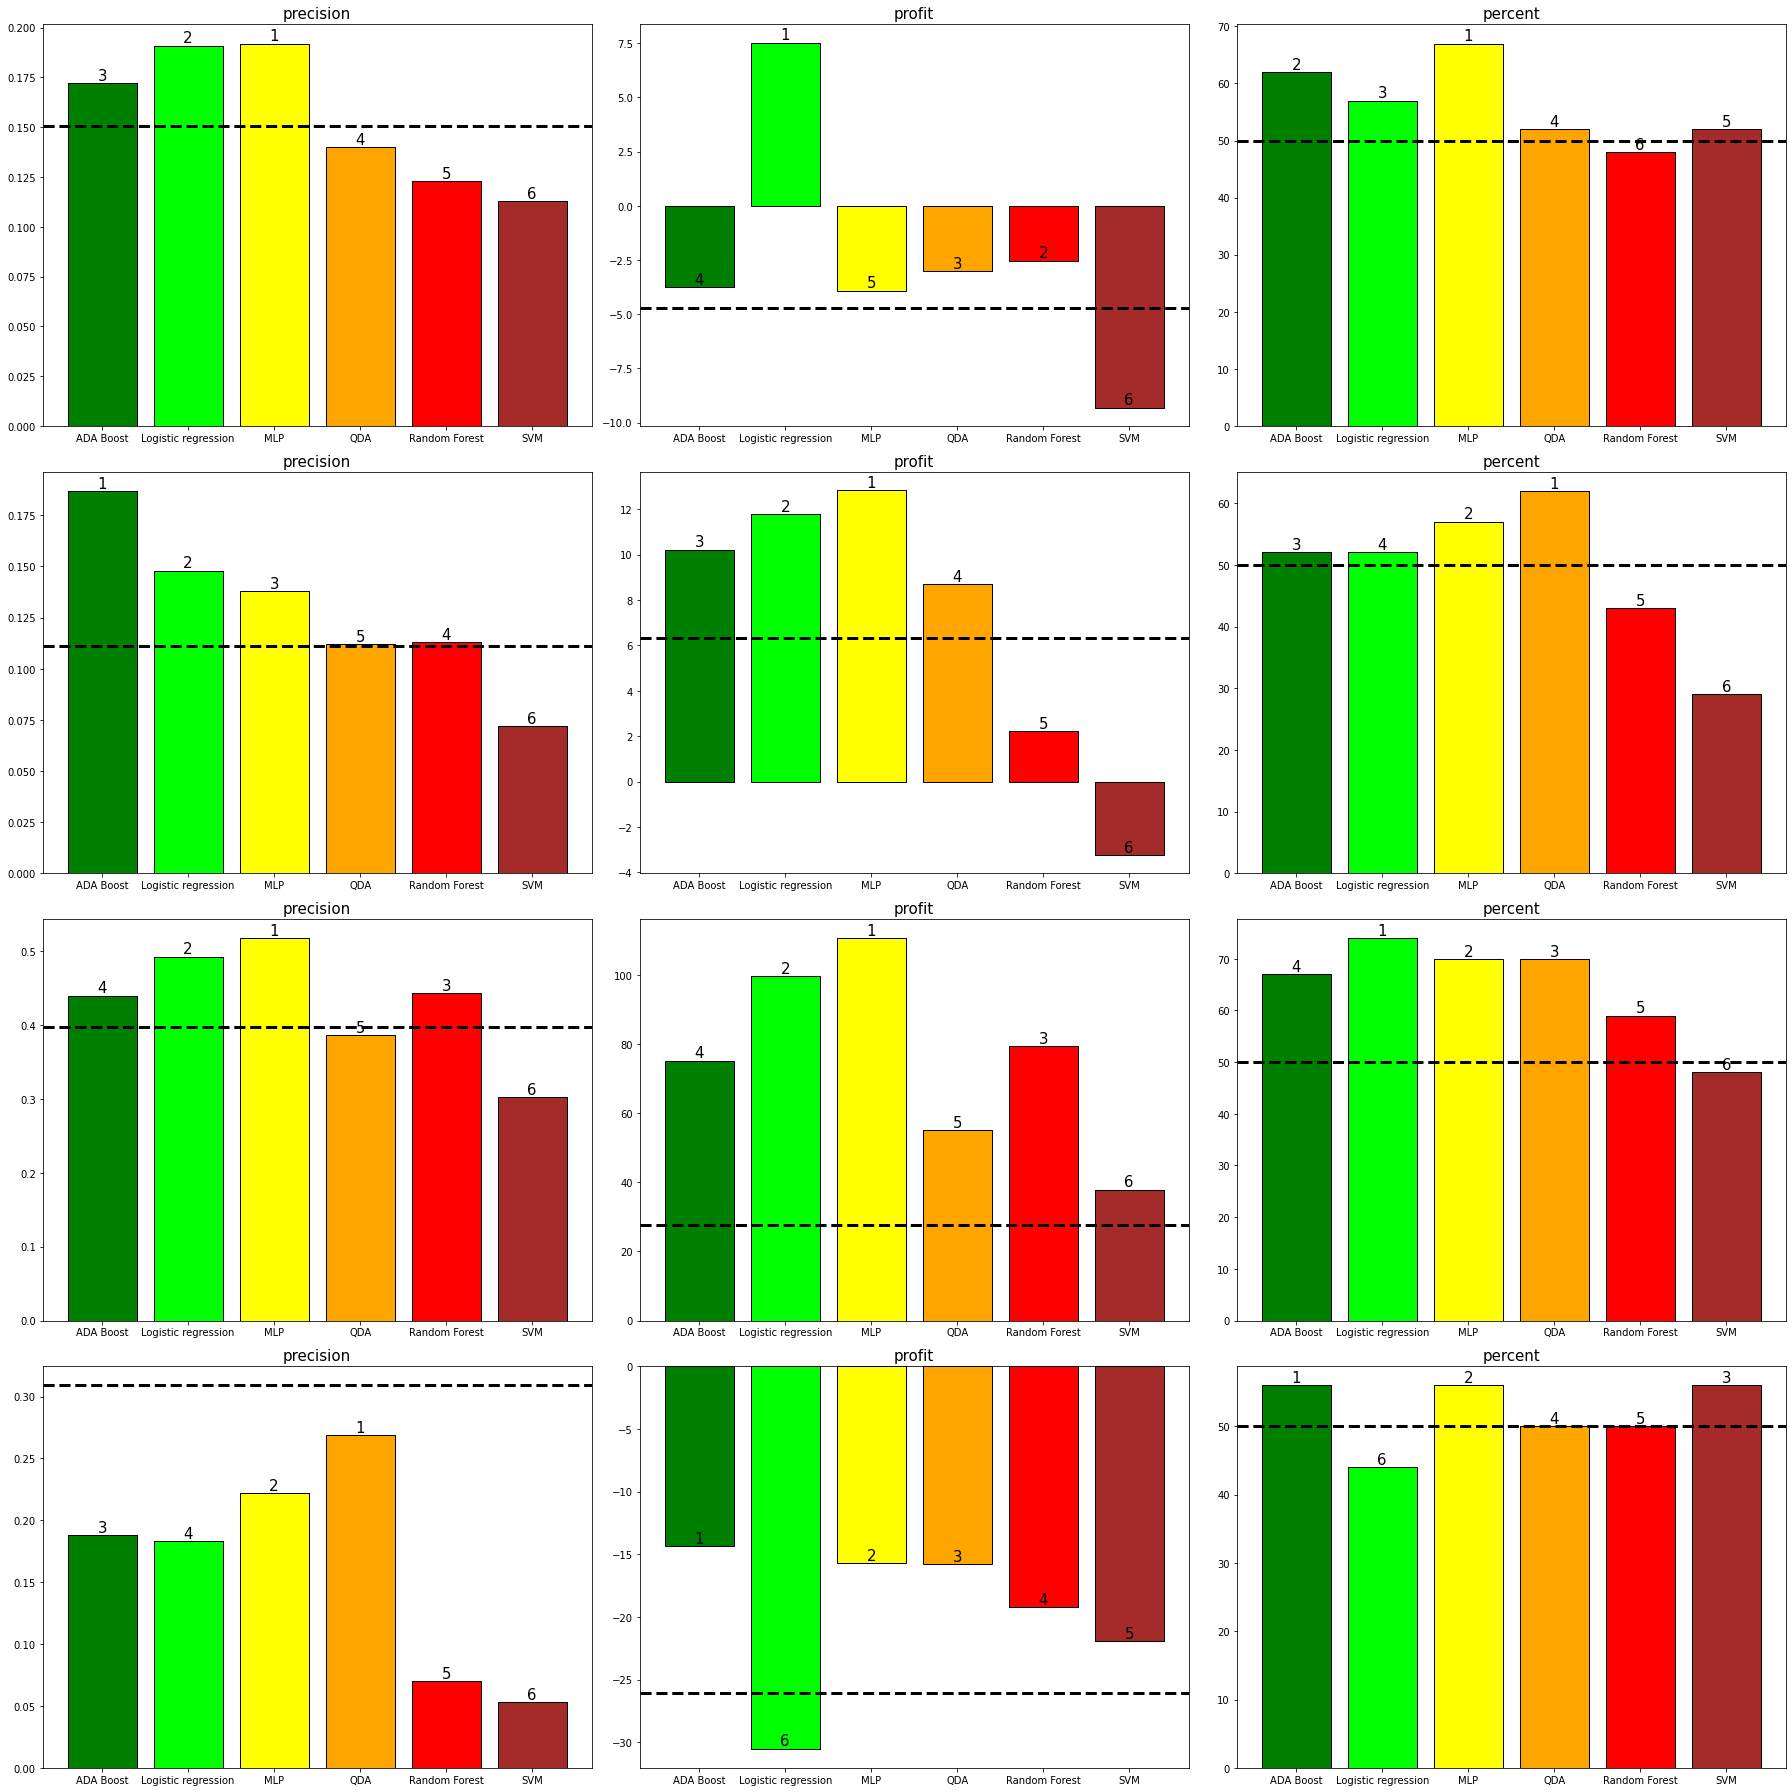

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('./data/PrecisionTesting/only20-2/fullresults20-2.xlsx', sheet_name='Sheet1', index_col=0)
colors = ['green', 'lime', 'yellow', 'orange', 'red', 'brown']
titles = {0: 'precision', 1: 'profit', 2: 'percent'}

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 25))

for i, ax_row in zip(df.index.astype(str), axs):
    for j, ax in zip(range(3), ax_row):
        start_col = j * 6
        end_col = (j + 1) * 6
        title = ax.set_title(titles[j % 3], fontsize=20)
        title.set_fontsize(15)
        values = df.loc[i].values[start_col:end_col]
        bars = ax.bar(x=range(6), height=values, color=colors, edgecolor='black')
        ax.set_xticks(range(6))
        ax.set_xticklabels([tick.split("-")[1] for tick in df.loc[i].index[start_col:end_col]], fontsize=10)
        scores = (-values).argsort().argsort() + 1  
        for bar, score in zip(bars, scores):
            ax.annotate(score, xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom', fontsize=15)
        ax.axhline(df.loc[i].values[j+18], color='black', linestyle='--', linewidth=3)
plt.savefig("pic.jpeg")       
plt.tight_layout()
plt.show()



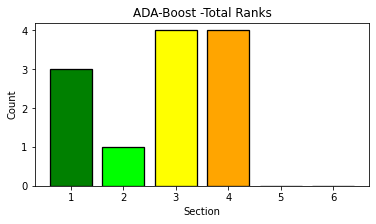

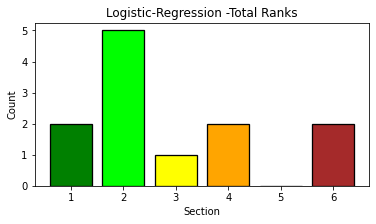

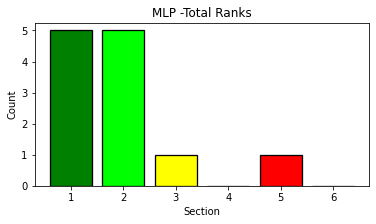

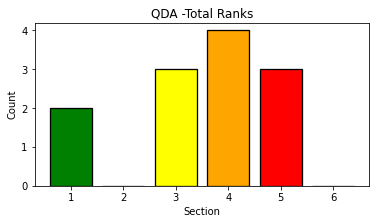

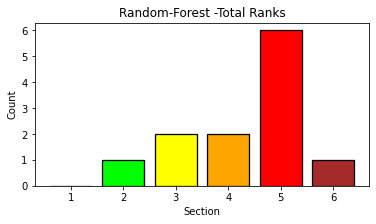

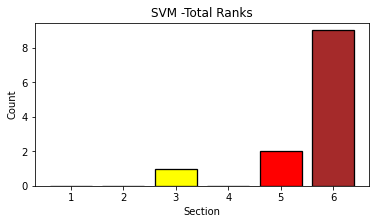

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_excel('./data/PrecisionTesting/only20-2/fullresults20-2.xlsx', sheet_name='Sheet1', index_col=0)

# Define the colors and titles
colors = ['green', 'lime', 'yellow', 'orange', 'red', 'brown']
titles = {0: 'precision', 1: 'profit', 2: 'percent'}
model_names = ['ADA-Boost', 'Logistic-Regression', 'MLP', 'QDA', 'Random-Forest', 'SVM']

model_counts = pd.DataFrame(index=model_names, columns=range(1, 7), data=0)

for i in df.index:
    for j in range(3):
        start_col = j * 6
        end_col = (j + 1) * 6
        values = df.loc[i].values[start_col:end_col]
        ranks = (-values).argsort().argsort() + 1
        for k, rank in enumerate(ranks):
            model_counts.loc[model_names[k], rank] += 1
# Loop through the models and create the bar charts
for model_name in model_names:
    model_data = model_counts.loc[model_name]
    plt.figure(figsize=(6,3))
    plt.bar(x=model_data.index, height=model_data.values, color=colors, edgecolor='black',linewidth = 1.3)
    plt.title(f'{model_name} -Total Ranks')
    plt.xlabel('Section')
    plt.ylabel('Count')
    plt.show()
